In [1]:
import warnings
warnings.filterwarnings("ignore")

# Working with graphs

This notebook gives a few examples how Pyrosm can be used together with other Python network analysis libraries. Before starting, ensure that you have read the [basic documentation about how to export graphs with Pyrosm](basics.html#export-street-networks-to-graph).

**Contents**:

1. [Find shortest path with `pyrosm + networkx + osmnx`](#find-shortest-path-with-pyrosm-networkx-osmnx)
2. [Calculate the catchment areas of hospitals in Estonia with `pyrosm + igraph`](#calculate-the-catchment-areas-of-hospitals-in-estonia-with-pyrosm-igraph).
3. Calculate the number of restaurant employees in Helsinki Region with `pyrosm + pandana` (TODO)


## Find shortest path with Pyrosm + NetworkX + OSMnx

This tutorial shows how to construct simple shortest path routing between selected source and destination addresses using [NetworkX](https://networkx.org/documentation/stable/) and [OSMnx](https://github.com/gboeing/osmnx).
Pyrosm is used for extracting the data from OSM PBF file and constructing the graph, while NetworkX provides the basic network analysis capabilities and OSMnx provides many useful functionalities that makes it easy to work with street networks.

In [19]:
from pyrosm import OSM, get_data
import osmnx as ox

# Initialize the reader
osm = OSM(get_data("helsinki_pbf"))

# Get all walkable roads and the nodes 
nodes, edges = osm.get_network(nodes=True)

# Check first rows in the edge 
edges.head()

,access,bicycle,bridge,cycleway,est_width,foot,footway,highway,int_ref,lanes,...,width,id,timestamp,version,tags,osm_type,geometry,u,v,length
0,None,None,None,None,None,None,None,unclassified,None,2,...,None,4236349,1380031970,21,"{""name:fi"":""Erottajankatu"",""name:sv"":""Skillnad...",way,"LINESTRING (24.94327 60.16651, 24.94337 60.16644)",1372477605,292727220,9.370
1,None,None,None,None,None,None,None,unclassified,None,2,...,None,4236349,1380031970,21,"{""name:fi"":""Erottajankatu"",""name:sv"":""Skillnad...",way,"LINESTRING (24.94337 60.16644, 24.94340 60.16641)",292727220,2394117042,4.499
2,None,None,None,None,None,None,None,unclassified,None,2,...,None,4243035,1543430213,12,"{""name:fi"":""Korkeavuorenkatu"",""name:sv"":""H\u00...",way,"LINESTRING (24.94567 60.16767, 24.94567 60.16763)",296250563,2049084195,4.174
3,None,None,None,None,None,None,None,unclassified,None,2,...,None,4243035,1543430213,12,"{""name:fi"":""Korkeavuorenkatu"",""name:sv"":""H\u00...",way,"LINESTRING (24.94567 60.16763, 24.94569 60.16744)",2049084195,60072359,21.692
4,None,None,None,None,None,None,None,unclassified,None,2,...,None,4243035,1543430213,12,"{""name:fi"":""Korkeavuorenkatu"",""name:sv"":""H\u00...",way,"LINESTRING (24.94569 60.16744, 24.94571 60.16726)",60072359,6100704327,19.083


Now we can easily export the nodes and edges into a directed NetworkX graph, as shown in the [basic documentation](basics.html#export-street-networks-to-graph):

In [20]:
# Create NetworkX graph
G = osm.to_graph(nodes, edges, graph_type="networkx")

In [21]:
G

As we can see the output is now a NetworkX MultiDiGraph. 

By default, the graph is exported in such a way that you can continue your analysis using `OSMnx` library that has many useful functions for analyzing and visualizing street networks. 

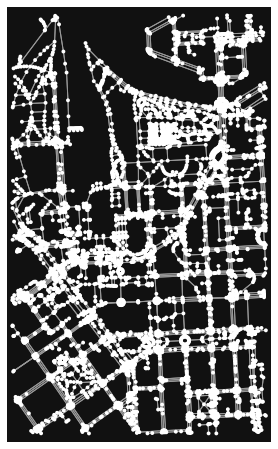

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [22]:
# Plot the graph with OSMnx
ox.plot_graph(G)

### Calculate shortest paths
Let's first see how we can now calculate shortest path between two addresses using `networkx` and `osmnx`:

In [23]:
source_address = "Bulevardi 5, Helsinki"
target_address = "Unioninkatu 40, Helsinki"

source = ox.geocode(source_address)
target = ox.geocode(target_address)

In [24]:
# Source and target are now points tuple of (x, y) coordinates
print(source)
print(target)

(60.1651049, 24.9387954)
(60.1726635, 24.949283641875)


Now we need to find the nearest graph nodes for our locations:

In [25]:
# Find the closest nodes from the graph
source_node = ox.get_nearest_node(G, source)
target_node = ox.get_nearest_node(G, target)

In [28]:
# Check the nodeids of the source/target node
print(source_node)
print(target_node)

537519894
1012307807


Now it is very easy to calculate the shortest path between those two addresses based on `length` using networkx function `shortest_path()`. OSMnx provides very handy function to plot our result on top of the graph:

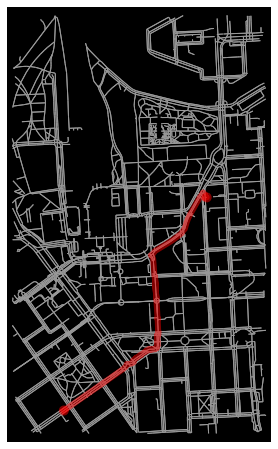

In [29]:
# Find shortest path (by distance)
import networkx as nx
route = nx.shortest_path(G, source_node, target_node, weight="length")
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')

That's it! Following this approach it is easy to find shortest paths between selected locations. 

You can read many more examples from [OSMnx examples gallery](https://github.com/gboeing/osmnx-examples).

```{note} 

Although NetworkX is very easy to use, it tends to use quite a lot of memory and it is relatively slow with large networks. Hence, the default output graph for pyrosm is iGraph, which performs much better and consumes less memory.  
```

## Calculate the catchment areas of hospitals in Estonia with pyrosm + igraph

Analyzing the catchment areas of specific services (such as hospitals) is a typical example where large scale spatial network analysis is used. In this example, we will see how pyrosm can be used together with igraph to conduct large scale network analysis and find the closest hospital for each building in Estonia in less than 10 minutes. The end result, will look something like following:

![Catchment areas of mainland hospitals in Estonia](img/Estonia_travel_distances_hospitals.png)

```{warning}

As OpenStreetMap is a voluntarily maintained data source, the hospitals extracted from OSM might not be up-to-date and some of them might be missing or otherwise incorrect. Furthermore, the hospitals represented in the data can be of any kind and not resticted e.g. to acute care hospitals. Lastly, it would make more sense to assess the number of inhabitants instead of buildings (after all, it's the people who need care, not the buildings). HOWEVER, the purpose of this example is just to give an idea what can be done, not to make a scientific assessment of health care accessibility in Estonia. If you find a mistake in the OSM data, please contribute by suggesting an edit at [www.openstreetmap.org/](https://www.openstreetmap.org/)

```

- Let's start by defining a few helper functions for our analysis:

In [22]:
from pyrosm import OSM, get_data
import geopandas as gpd
import pandas as pd
from sklearn.neighbors import BallTree
import numpy as np
import mapclassify as mc
import matplotlib.pyplot as plt
import time

def get_igraph_nodes(G):
    """Retrieves a frame from nodes of the igaph"""
    attributes = G.vs.attribute_names()
    if len(attributes) == 0:
        raise ValueError("Nodes does not have data.")
    data = {name: G.vs[name] for name in attributes}
    if "geometry" in attributes:
        return gpd.GeoDataFrame(data, 
                                geometry="geometry", 
                                crs="epsg:4326")
    return pd.DataFrame(data)

def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""
    tree = BallTree(candidates, leaf_size=15, metric='haversine')
    distances, indices = tree.query(src_points, k=k_neighbors)
    distances = distances.transpose()
    indices = indices.transpose()
    closest = indices[0]
    closest_dist = distances[0]
    return (closest, closest_dist)

def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    
    For further info, take a look this lesson: 
        https://autogis-site.readthedocs.io/en/latest/notebooks/L3/06_nearest-neighbor-faster.html
    """
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name
    right = right_gdf.copy().reset_index(drop=True)
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: 
                                                          (geom.x * np.pi / 180, geom.y * np.pi / 180)
                                                         ).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: 
                                                         (geom.x * np.pi / 180, geom.y * np.pi / 180)
                                                        ).to_list())
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)
    closest_points = right.loc[closest]
    closest_points = closest_points.reset_index(drop=True)
    if return_dist:
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
    return closest_points

def find_nearest_nodeids(nodes, src_gdf):
    """Finds the nearest node-ids for all points in 'src_gdf'."""
    nearest = nearest_neighbor(src_gdf, nodes, return_dist=True)
    return list(set(nearest["node_id"].values)), nearest["distance"].values


- Retrieve the network, buildings and hospitals for Estonia:

In [6]:
# Get the data
osm = OSM(get_data("estonia"))
nodes, edges = osm.get_network(nodes=True, network_type="driving")
hospitals = osm.get_pois({"amenity": ["hospital"]})
buildings = osm.get_buildings()

# Track the number of buildings
building_cnt = len(buildings)

- Create the directed graph for Estonia:

In [7]:
# Create graph
G = osm.to_graph(nodes, edges)

- Get nodes from the graph
   - This step needs to be done because some of the nodes originally parsed from the street network are likely to be dropped out when the graph is 
generated (because unconnected edges are removed).

In [8]:
nodes = get_igraph_nodes(G)

- Find closest network node for each hospital:

In [30]:
# Ensure that all hospitals are represented as a point (take centroid)
# Warning: using a centroid is not necessarily a smart thing if doing the analysis for real, 
# but for the sake of simplicity we assume that the centroid of the hospital polygon 
# is the destination to be reached.
hospitals["geometry"] = hospitals.centroid

# Get a list of nearest source-ids of the network to all hospitals (with distance)
# Warning: Using the nearest node (in stead of nearest edge) can produce slightly incorrect results, 
# but for the sake of simplicity we use nodes.
src_ids, euclidean_distance = find_nearest_nodeids(nodes, hospitals)

<ipython-input-30-fded1dfb1b5b>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hospitals["geometry"] = hospitals.centroid


- Calculate travel distances to all hospitals in Estonia:

In [31]:
# Keep track of how many new columns are inserted to the frame
src_cnt = len(src_ids)

# Iterate over hospitals and calculate the network distances
for src_id, distance_to_closest_node in zip(src_ids, euclidean_distance):
    #print(f"Calculate shortest paths to {src_id}")
    
    # Calculate shortest path lengths to given locations
    path_lengths = G.shortest_paths_dijkstra(source=src_id, weights="length", mode="IN")
    
    # Add the euclidean distance between the hospital and closest node in the network 
    # to keep track of the door-to-door travel distance
    path_lengths = np.array(path_lengths) + distance_to_closest_node

    # Attach the path lenghts to nodes
    nodes[f"distance_to_{src_id}"] = path_lengths[0]

At this point, we have distance from **all nodes** in the network to each hospital. They are stored as separate columns in the nodes GeoDataFrame.

- Next, we calculate which of the hospitals is the closest one for each node:

In [32]:
# Calculate distance to the closest hospital
nodes["distance_to_closest"] = nodes.iloc[:, -src_cnt:].min(axis=1)

# At this point you could already see the catchment areas from each road network node 
# to the closest hospital.
# Comment out the following if you want to see:
# ax = nodes.plot(column="distance_to_closest", cmap="RdYlBu", markersize=0.5)

At this point, we have calculated the catchments for each hospital, but those are not linked yet to buildings.

- Let's find the closest node for each building and keep track of the distance between them:

In [33]:
# Find closest node for each building (centroid)
# Warning: Again, taking a centroid of a building might not be the smartest thing to do for real..
# But for the sake of simplicity, we do it such a way
buildings["centroid"] = buildings.centroid
buildings = buildings.set_geometry("centroid")

# Note: With ~900000 x ~830000 point pairs, 
# this takes a few minutes to solve. 
# Also keep track of the distance between the points.
closest = nearest_neighbor(buildings, nodes, return_dist=True)
buildings["node_id"] = closest["node_id"]
buildings["distance_to_closest_node"] = closest["distance"]

<ipython-input-33-a5f00cee9271>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings["centroid"] = buildings.centroid


- Now we can associate the distance information to closest hospital into the buildings:

In [34]:
# Link the distance information
access = buildings.merge(nodes[["distance_to_closest", "node_id"]], on="node_id")

# Add the (Euclidean) distance between building 
# and the closest node in the road network to get a full "door-to-door" distance
access["distance"] = access["distance_to_closest"] + access["distance_to_closest_node"]

# Calculate distance in kilometers (meters by default)
access["distance_km"] = (access["distance"] / 1000).round(1)

- Some of the buildings might be very far from the closest road. Drop buildings that are further than 5km from the road:

In [35]:
# Drop such buildings that are further than 5 km from closest road
access = access.loc[access["distance_to_closest_node"]<=5000]

Notice: the previous step will remove most of the buildings from the islands of Saarenmaa and Hiiumaa, because those are not linked to the mainland network (requires taking a ferry).

- Finally, to make things a bit more interesting, we can also classify the distances and calculate some statistics:

In [66]:
# Classify distances to every 2 km zones, specify that the upper boundary is 50 kilometer
# everything above this will be put into a same class
upper_boundary_distance = 50
width = 5

# Use self-defined classification
classifier = mc.UserDefined(access["distance_km"], bins=[x for x in range(0, int(upper_boundary_distance)+1, width)])
access["cls"] = access[["distance_km"]].apply(classifier)
# Replace the class numbers to distance categories (e.g. 0-2, 2-4 .. km etc.)
access["travel_distance"] = access["cls"].replace({k: v 
                                                   for k, v in 
                                                   zip([x for x in range(len(classifier.bins))], 
                                                       classifier.bins)})

# Set all values over 50 km as 51 (to improve how the colorscale works)
access.loc[access["travel_distance"] > upper_boundary_distance, "travel_distance"] = upper_boundary_distance + 1

# Convert the observation counts as percentages
classifier.counts = (classifier.counts / classifier.counts.sum()).round(3)

# Convert stats to dataframe
bins = classifier.bins.astype(int)
categories = np.vstack([bins[:-1], bins[1:]]).T
categories = [f"{low}-{high}" for low, high in categories]
access_zone_classes = pd.DataFrame({"Distance": categories, "% of buildings": classifier.counts[1:]})

Finally, we can plot the results as a map:

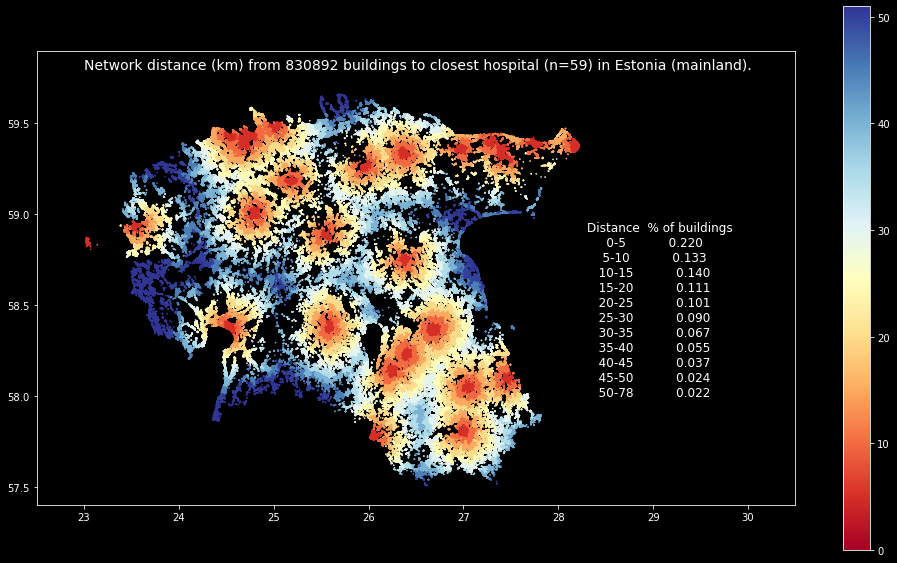

In [77]:
plt.style.use('dark_background')
ax = access.plot(column="travel_distance", markersize=0.5, legend=True, cmap="RdYlBu", figsize=(17,10))
# Adjust the map extent
ax.set_xlim(22.5, 30.5)
ax.set_ylim(57.4, 59.9)
# Add some useful info
ax.text(23, 59.8, f"Network distance (km) from {building_cnt} buildings to closest hospital (n={src_cnt}) in Estonia (mainland).", {"size": 14})
ax.text(28.3, 58.0, access_zone_classes.to_string(index=False), {"size": 14});

The map shows the catchment areas of all hospitals in mainland Estonia based on network distance between buildings and the closest hospital. It is possible to spot the 5 kilometer distance zones around each hospital quite easily, and the summary statistics reveal that around 22 % of the buildings in Estonia are within 5 kilometer from the closest hospital, and ~50 % of the buildings in Estonia are within 15 kilometers from closest hospital (*however, remember/see the caveats in the beginning of this section about the data quality and the rationale*). 

This example shows, how `pyrosm` can be used to conduct even national level analysis quite easily and fairly efficiently. The **total time running this tutorial takes about 8.5 minutes** (with a laptop having 16GB memory, SSD drive, and Intel Core i5-8250U CPU 1.6 GHZ). This included all steps from downloading the OSM data, parsing the required datasets (steets, buildings and hospitals), exporting the network to graph, conducting the network distance calculations and parsing the statistics (plotting was not taken into account). 

```{warning}

Although `pyrosm` works fairly well with large datasets, conducting national level analyses still consume a fair amount of memory. Hence, be aware that you might end up having memory errors if you try to conduct national level analyses without sufficient RAM. Repeating this example with 16 GB of RAM should work well in smaller countries (~up to 150MB size of the PBF), but conducting similar analysis e.g. in Finland (PBF size ~539MB) would most likely end up with memory error. (*the idea is to allow optimizing the memory usage in the future versions of `pyrosm`*, see [#87](https://github.com/HTenkanen/pyrosm/issues/87)) 
```